In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(10)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.21:46913 Dashboard: http://10.148.1.21:8787/status,Cluster Workers: 20 Cores: 80 Memory: 1000.00 GB


___________
# 1. First try to read (Zach's) data, and store as .nc files 
## (I am more familar with .nc or .zarr formats)

In [6]:
# the path where LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
# the path where processed data will be stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'
# variable 
v = 'Theta'

In [6]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201x52.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        Theta = np.fromfile(filenames[i] , dtype='>f').reshape(52,201,177)
        Theta = np.array(Theta)
        Theta = xr.DataArray(Theta, dims=['depth','lat','lon'])
        Theta = np.real(Theta).rename('Theta')
        #Theta = Theta.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                Theta.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


# 2. Add coordinates and put variables into one xarray file

In [32]:
filenames = sorted(glob(out_dir+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
ds

Number of files processed: 9415


<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Dimensions without coordinates: depth, lat, lon, time
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>

In [33]:
LLC_XC = np.fromfile(LLC_data_folder+"grid/XC_177x201", dtype='>f').reshape(201,177)
LLC_XC = np.array(LLC_XC)
LLC_XC = xr.DataArray(LLC_XC, dims=['lat','lon'])
LLC_XC = np.real(LLC_XC).rename('LLC_XC')

In [34]:
LLC_YC = np.fromfile(LLC_data_folder+"grid/YC_177x201", dtype='>f').reshape(201,177)

LLC_YC = np.array(LLC_YC)
LLC_YC = xr.DataArray(LLC_YC, dims=['lat','lon'])
LLC_YC = np.real(LLC_YC).rename('LLC_YC')

In [35]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [36]:
ds = ds.assign_coords(depth=Depth) 
ds = ds.assign_coords(time=np.arange(9415)*3600/86400) 
ds = ds.assign_coords(XC=LLC_XC) 
ds = ds.assign_coords(YC=LLC_YC) 
lat = LLC_YC.isel(lon=1)
lon = LLC_XC.isel(lat=1)
ds = ds.assign_coords(lat=lat) 
ds = ds.assign_coords(lon=lon)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
    XC       (lat, lon) >f4 -18.03125 -18.010416 -17.989584 -17.96875 ...
    YC       (lat, lon) >f4 47.404716 47.404716 47.404716 47.404716 ...
  * lat      (lat) >f4 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) >f4 -18.03125 -18.010416 -17.989584 -17.96875 -17.947916 ...
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>

 data size: 69.7 GB


# 3. Save the whole data into one .zarr file

In [37]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

file_out = out_dir_zarr+'/%s_total.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     


CPU times: user 1min 44s, sys: 8.4 s, total: 1min 53s
Wall time: 2min 51s


In [9]:
ds = xr.open_zarr(out_dir_zarr+v+'_total.zarr')
ds
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))


 data size: 69.7 GB


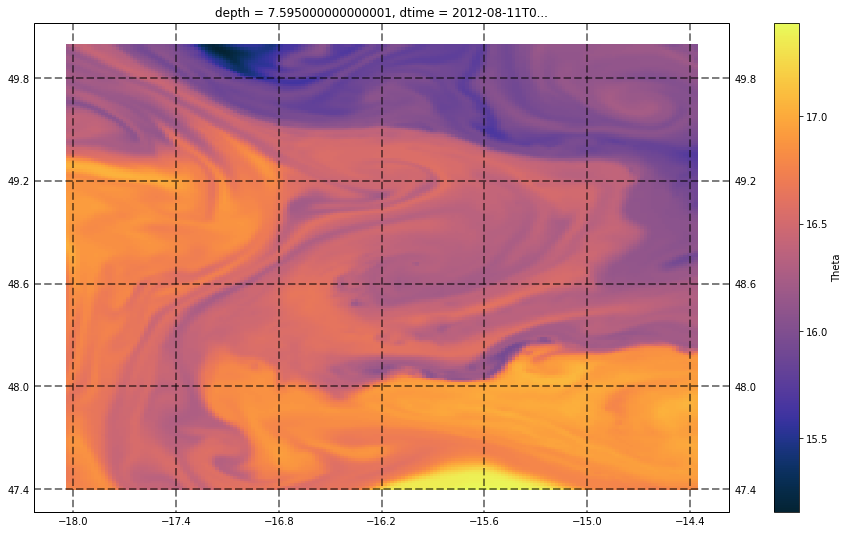

In [10]:
tem = ds['Theta'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.thermal)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

CPU times: user 57 s, sys: 4.56 s, total: 1min 1s
Wall time: 1min 38s


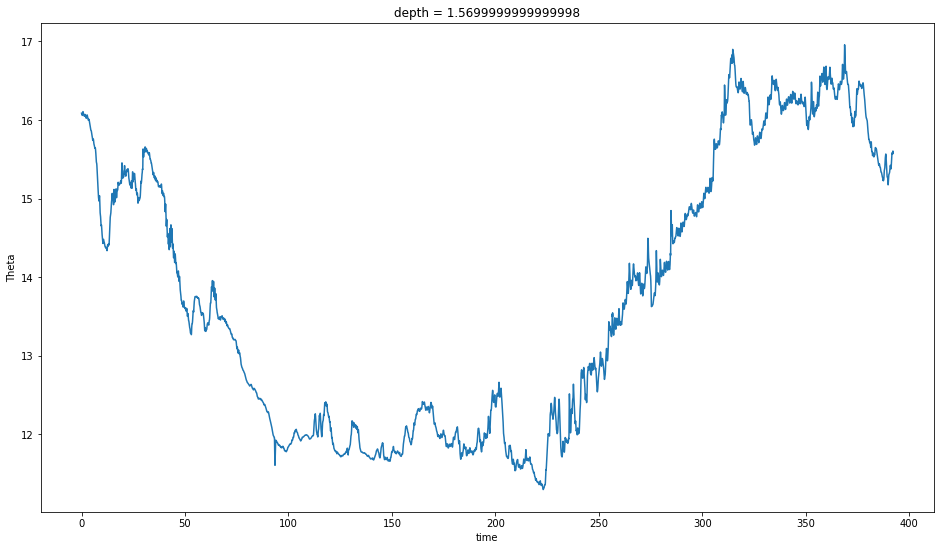

In [11]:
fig = plt.figure(figsize=(16,9))

%time ds['Theta'].isel(depth=1, lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

# 4. Choose nine points (analog of the nine moorings)

In [46]:
lat_mooring = np.array([ 48.6875,  48.6940,  48.7480,  48.7000,  48.7485,  48.6803,  48.6290,  48.6780,  48.6290])
lon_mooring = np.array([-16.1875, -16.1740, -16.0945, -16.2060, -16.2762, -16.1740, -16.0990, -16.2050, -16.2775])


In [48]:
Temperature_mooring_site = ds.sel(lat=lat_mooring, lon = lon_mooring, method='nearest')
Temperature_mooring_site

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 9, lon: 9, time: 9415)
Coordinates:
    XC       (lat, lon) float32 dask.array<shape=(9, 9), chunksize=(9, 9)>
    YC       (lat, lon) float32 dask.array<shape=(9, 9), chunksize=(9, 9)>
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 48.68508 48.697998 48.749645 48.697998 48.749645 ...
  * lon      (lon) float32 -16.177084 -16.177084 -16.09375 -16.197916 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 9, 9), chunksize=(1, 52, 9, 9)>

In [49]:
out_dir_mooring = '/home1/scratch/xyu/OSMOSIS_llc4320/mooring_site/'

file_out = out_dir_mooring+'/%s_mooring.nc'%(v)
          
Temperature_mooring_site.to_netcdf(file_out, mode='w', unlimited_dims=['time'])


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 2.64 MB detected in task graph: 
  ("('getitem-9902461648b5e3e3fe44530d628b69b6', 0,  ... 5240>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))
tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x2aab0d36de80>>
Traceback (most recent call last):
  File "/home1/datahome/xyu/.minicon

In [13]:
cluster.scheduler.close()

<Future finished result=None>